In [15]:
import os
from datetime import datetime
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from matplotlib import pyplot as plt

# Assignment 1

In [16]:
A = np.array([[0.5, 1.2],
              [0.3, 0.2]]).T

eigenvalues_A = np.linalg.eigvals(A)
print(f"Eigenvalues for A:{eigenvalues_A}")
print(f"Is every Eigenvalue abs(<1)? {[abs(i) < 1 for i in eigenvalues_A]}")

B1 = np.array([[0.6, 0.4],
               [0.5, 0.2]])
B2 = np.array([[0.1, 0.3],
               [0.2, 0.6]])

additive_matrix = np.block([
    [B1, B2],
    [np.eye(2), np.zeros((2, 2))]
])

eigenvalues_B = np.linalg.eigvals(additive_matrix)
print(f"Eigenvalues for B:{eigenvalues_B}")
print(f"Is every Eigenvalue abs(<1)? {[abs(i) < 1 for i in eigenvalues_B]}")

Eigenvalues for A:[ 0.96846584 -0.26846584]
Is every Eigenvalue abs(<1)? [np.True_, np.True_]
Eigenvalues for B:[ 1.30849576e+00  1.69163780e-01 -3.92066051e-17 -6.77659542e-01]
Is every Eigenvalue abs(<1)? [np.False_, np.True_, np.True_, np.True_]


## 1 a
Since all abs Eigenvalues for A are < 1, stationarity is fulfilled. 
## 1b
Since one abs Eigenvalue for B is > 1, stationarity is not fulfilled.

# Assignment 2

## 2a

Common range of observation_date: 1959-01-01 00:00:00 to 2025-04-01 00:00:00


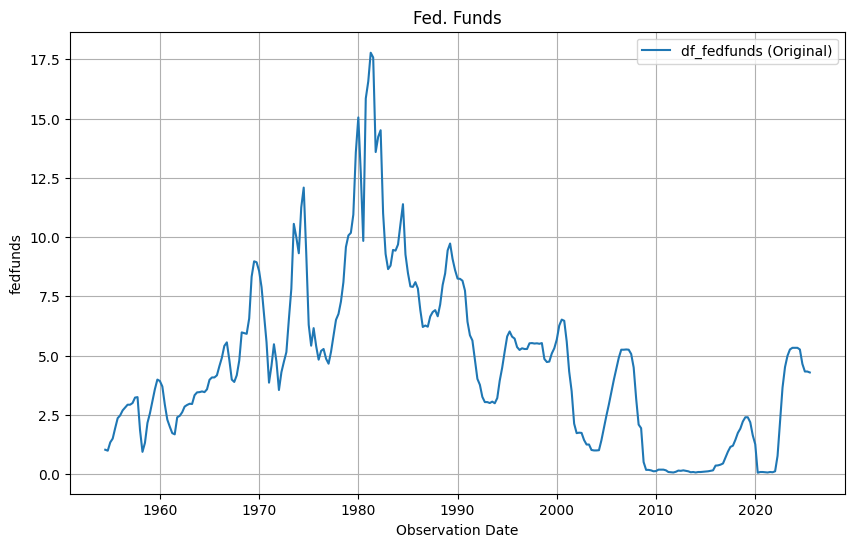

df_fedfunds Index(['observation_date', 'fedfunds'], dtype='object')


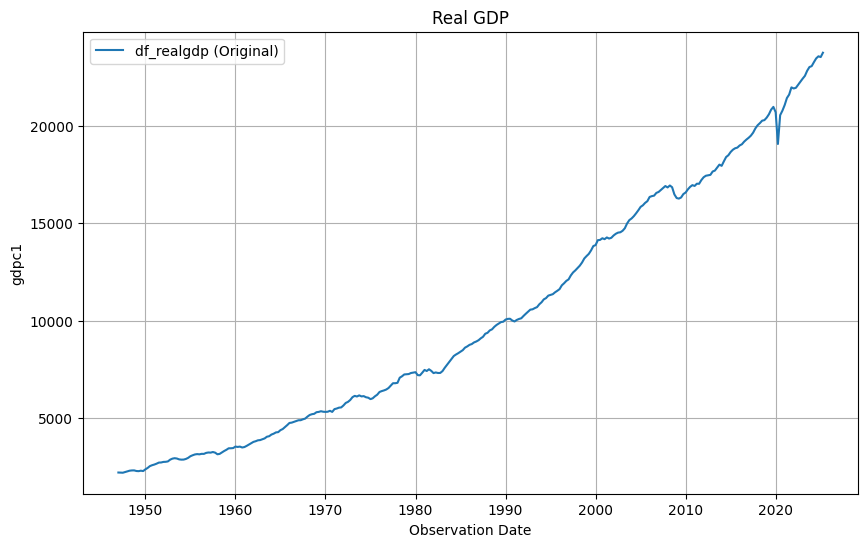

df_realgdp Index(['observation_date', 'gdpc1_log'], dtype='object')


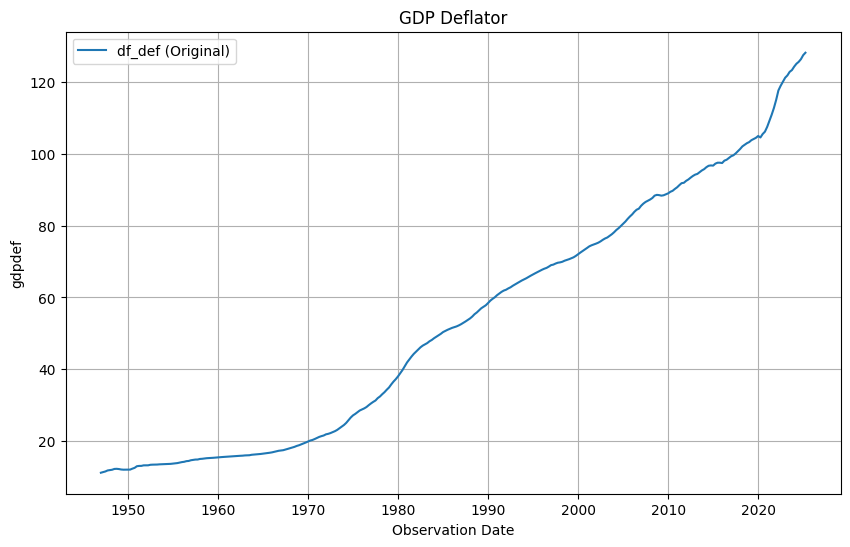

df_def Index(['observation_date', 'gdpdef_log'], dtype='object')


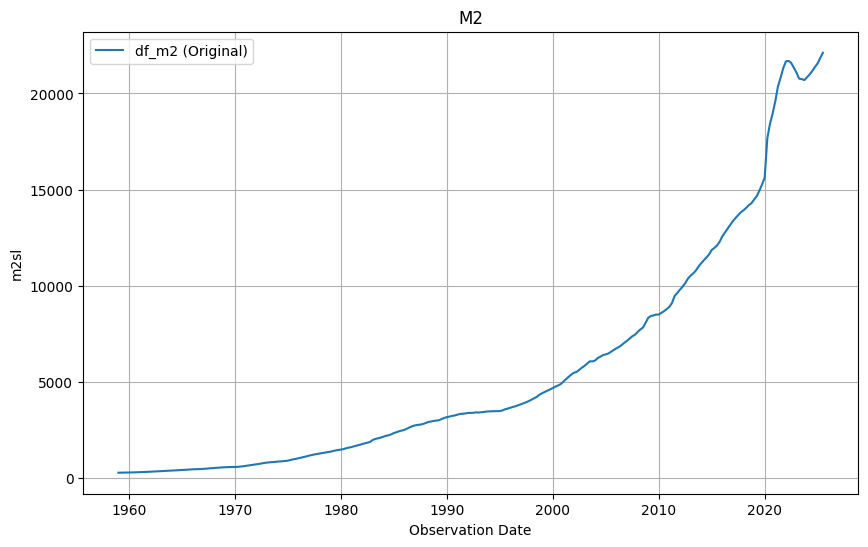

df_m2 Index(['observation_date', 'm2sl_log'], dtype='object')


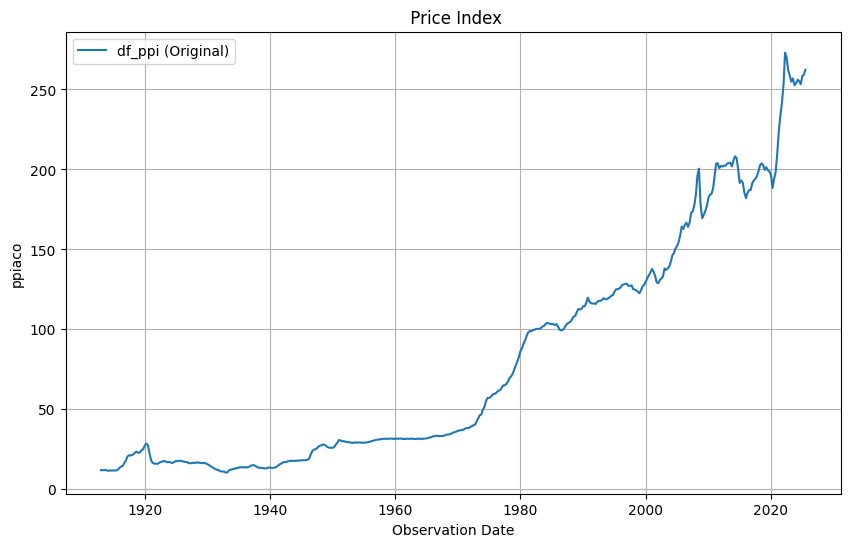

df_ppi Index(['observation_date', 'ppiaco_log'], dtype='object')


In [17]:
file_names = [
    "FEDFUNDS.csv",
    "GDPC1.csv",
    "GDPDEF.csv",
    "M2SL.csv",
    "PPIACO.csv",
]

df_names = [
    "df_fedfunds",
    "df_realgdp",
    "df_def",
    "df_m2",
    "df_ppi",
]

clear_names = {
    "df_fedfunds":"Fed. Funds",
    "df_realgdp": "Real GDP",
    "df_def": "GDP Deflator",
    "df_m2": "M2",
    "df_ppi":" Price Index",
}
data_folder = "data/task_2/"

dfs = {}

for file_name, df_name in zip(file_names, df_names):
    df = pd.read_csv(f"{data_folder}{file_name}")
    df.columns = df.columns.str.lower()
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    dfs[df_name] = df

common_start = max(df["observation_date"].min() for df in dfs.values())
common_end = min(df["observation_date"].max() for df in dfs.values())
print(f"Common range of observation_date: {common_start} to {common_end}")

for df_name, df in dfs.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df["observation_date"], df.iloc[:, 1], label=f"{df_name} (Original)")
    plt.title(f"{clear_names[df_name]}")
    plt.xlabel("Observation Date")
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.grid()
    plt.show()
    globals()[df_name] = df
    if df_name != 'df_fedfunds':
        df[df.columns[1]] = np.log(df[df.columns[1]])
        df = df.rename(columns={df.columns[1]: f"{df.columns[1]}_log"})
    dfs[df_name] = df
    globals()[df_name] = df 
    
    print(df_name, df.columns)

## 2b

In [18]:
df_agg = pd.concat([
    df_realgdp.set_index("observation_date")["gdpc1_log"],
    df_def.set_index("observation_date")["gdpdef_log"],
    df_ppi.set_index("observation_date")["ppiaco_log"],
    df_fedfunds.set_index("observation_date")["fedfunds"],
    df_m2.set_index("observation_date")["m2sl_log"],
], axis=1).dropna()

df_agg.columns = ["GDPC1", "GDPDEF", "PPIACO", "FEDFUNDS", "M2SL"]

model = VAR(df_agg)
lag_order = model.select_order(8)
print("Selected lag order based on criteria:")
print(lag_order.summary())

p_aic = lag_order.selected_orders["aic"]
p_bic = lag_order.selected_orders["bic"]

print(f"AIC best p: {p_aic}")
print(f"BIC pest p: {p_bic}")

Selected lag order based on criteria:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -13.25      -13.18   1.758e-06      -13.22
1      -38.16      -37.75   2.672e-17      -38.00
2      -39.77     -39.01*   5.345e-18      -39.47
3      -39.94      -38.84   4.523e-18     -39.50*
4     -39.94*      -38.50  4.513e-18*      -39.36
5      -39.89      -38.10   4.744e-18      -39.17
6      -39.90      -37.77   4.706e-18      -39.05
7      -39.80      -37.32   5.240e-18      -38.80
8      -39.73      -36.90   5.661e-18      -38.59
-------------------------------------------------
AIC best p: 4
BIC pest p: 2


Althoug the BIC shows advantages in penalizing extra lags and therefore prevents the model from becoming overly complex, we will proceed with AIC. The rationale is that this model tends to better approximate the truth when dealing with complex processes. Quarterly macroeconomic and financial time series may come with delayed responses, which may require an extended lag structure. This makes the AIC preferrable. 

## 2c

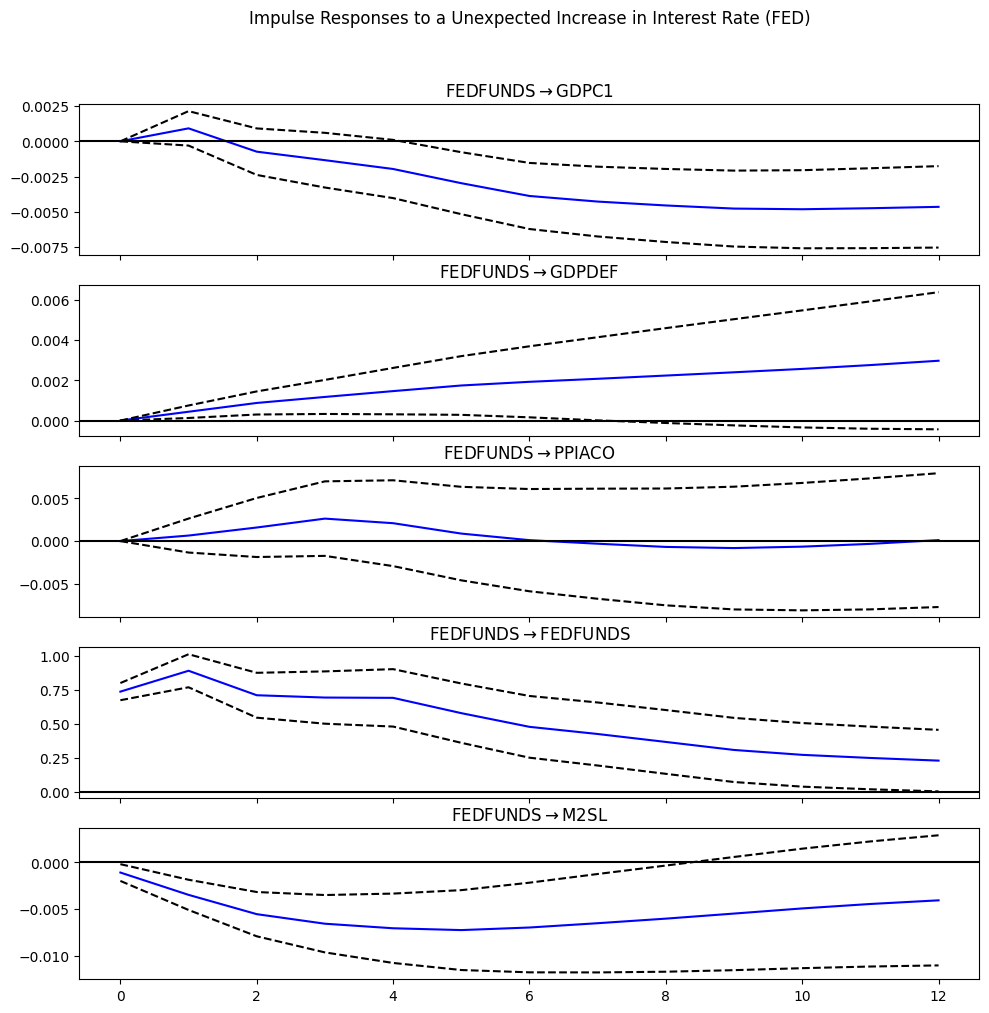

In [19]:
# ensure we follow this order: "GDPC1", "GDPDEF", "PPIACO", "FEDFUNDS", "M2SL"
fitted_model = model.fit(p_aic)

periods = 12 

irf_12 = fitted_model.irf(periods)
irf_12.plot(
    orth=True,
    impulse="FEDFUNDS",
    signif=0.05
)
plt.suptitle(
    "Impulse Responses to a Unexpected Increase in Interest Rate (FED)",
    y=1.02
)
plt.show()


## 2d
An unexpected increase in interest rates leads to an immediate reduction in money supply, which is confirmed by the model above.
Contractionary monetary policy also results in a decrease in economic activity, which is illustrated by the lagged decline in real GDP.
The qualitative direction as well as the delay in response are economically plausible. Ongoing economic activity is less affected by the shock than future investment accounting for this delay.

Moreover, the GDP deflator shows a weak but slightly positive response. From an economic perspective, contractionary monetary policy is expected to reduce inflationary pressures and the price level over time. This may be a limitation of the model in capturing inflation dynamics, known as the price puzzle. Monetary contraction may reflect the central bank’s response to expected inflation in the future.

# Task 3

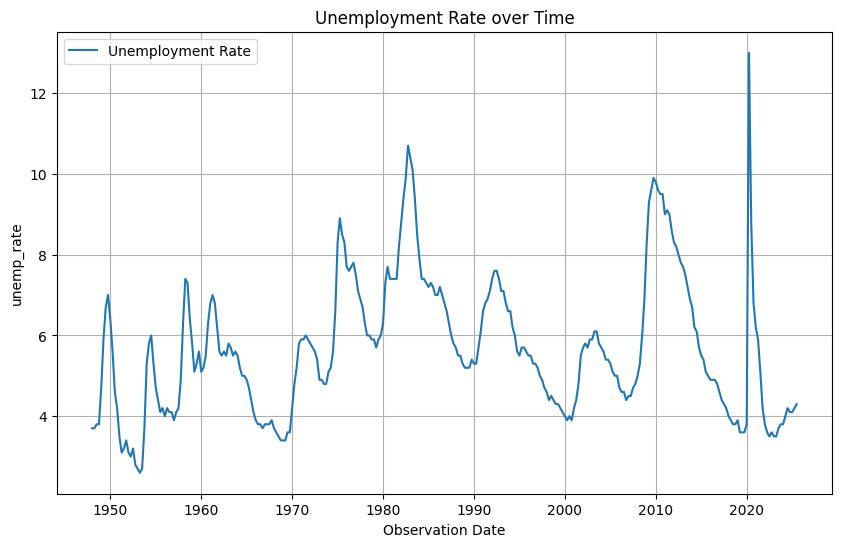

In [20]:
df_unemp = pd.read_csv('data/task_3/UNRATE.csv')
df_unemp.columns = df_unemp.columns.str.lower()
df_unemp["observation_date"] = pd.to_datetime(df_unemp["observation_date"])

plt.figure(figsize=(10, 6))
plt.plot(df_unemp["observation_date"], df_unemp["unrate"], label="Unemployment Rate")
plt.title("Unemployment Rate over Time")
plt.xlabel("Observation Date")
plt.ylabel("unemp_rate")
plt.legend()
plt.grid()
plt.show()

p aic is 2


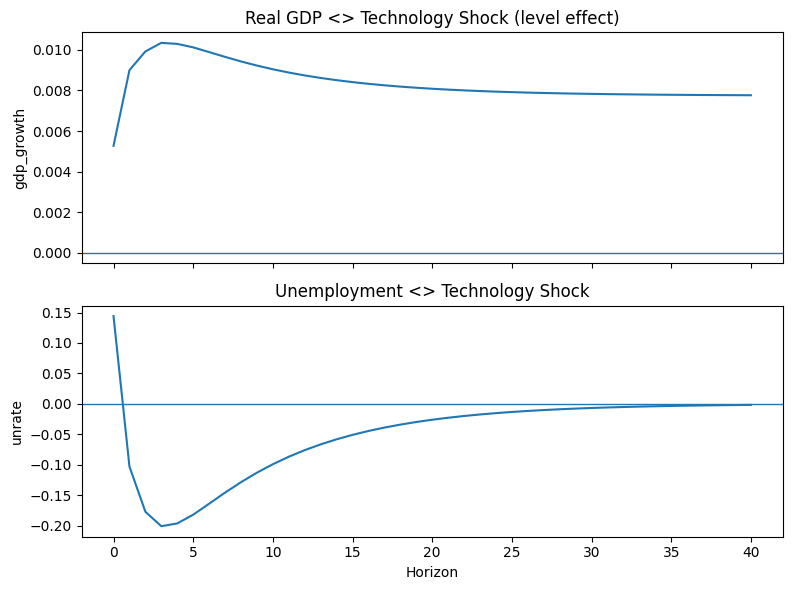

In [21]:
#GDP Growth
df_realgdp["gdp_growth"] = df_realgdp["gdpc1_log"].diff()

#merge with unemployment rate
df_gdp_unrate = pd.merge(
    df_realgdp[["observation_date", "gdp_growth"]],
    df_unemp[["observation_date", "unrate"]],
    on="observation_date"
).dropna().sort_values("observation_date")

df_gdp_unrate = df_gdp_unrate[["gdp_growth", "unrate"]].dropna()

#fit model
var_model = VAR(df_gdp_unrate)
lag_select = var_model.select_order(maxlags=12)

p = lag_select.aic
print(f"p aic is {p}")

var_results = var_model.fit(p)

#BQ
A = var_results.coefs
A_sum = A.sum(axis=0)
k = var_results.neqs
F = np.linalg.inv(np.eye(k) - A_sum)
Sigma_e = var_results.sigma_u

# long-run covariance 
LR_cov = F @ Sigma_e @ F.T

# Cholesky Decomposition
C1 = np.linalg.cholesky(LR_cov)
B = (np.eye(k) - A_sum) @ C1

#IRF
periods = 40
irf_analysis = var_results.irf(periods)
Psi = irf_analysis.irfs 
struct_irfs = np.zeros((periods, k, k))
irf_struct = np.array([Psi[h] @ B for h in range(periods + 1)])

# gdp growth
resp_gdp = irf_struct[:, 0, 0]
resp_gdp_level = np.cumsum(resp_gdp)

#unemployment reate
resp_unrate = irf_struct[:, 1, 0]

#plot
periods = np.arange(periods + 1)
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax[0].plot(periods, resp_gdp_level)
ax[0].axhline(0, linewidth=1)
ax[0].set_title("Real GDP <> Technology Shock (level effect)")
ax[0].set_ylabel("gdp_growth")

ax[1].plot(periods, resp_unrate)
ax[1].axhline(0, linewidth=1)
ax[1].set_title("Unemployment <> Technology Shock")
ax[1].set_ylabel("unrate")
ax[1].set_xlabel("Horizon")

plt.tight_layout()
plt.show()

The above modelled technology shock response makes sense from an economic perspective. A technology shock comes with uncertainty, leading to disruptions on the job market. However, the effect on the unemployment eventually evens out after compensating for the initial increase in unemployment. This may occur due to the increased capacity of companies due to the introduction of new technology. The magnitude of the initial dramatic change in unemployment rate however may be a modelling limitation. The qualitative patterns are economically reasonable, however.

When it comes to the GDP, the increase in productivity accounts for an intial 'boom' in economic activity. Since the technology persists and supports economic activity, this rise in GDP remains throughout the time horizon. 

# Task 4

## 4a
### TGARCH
The TGARCH model is an extension of the standard GARCH model that allows volatility to respond differently to positive and negative shocks. In specific, negative shocks drive volatility more than comparable positive shocks in absolute terms. This asymmetric volatility behavior is commonly observed in financial time series, especially in equity markets.


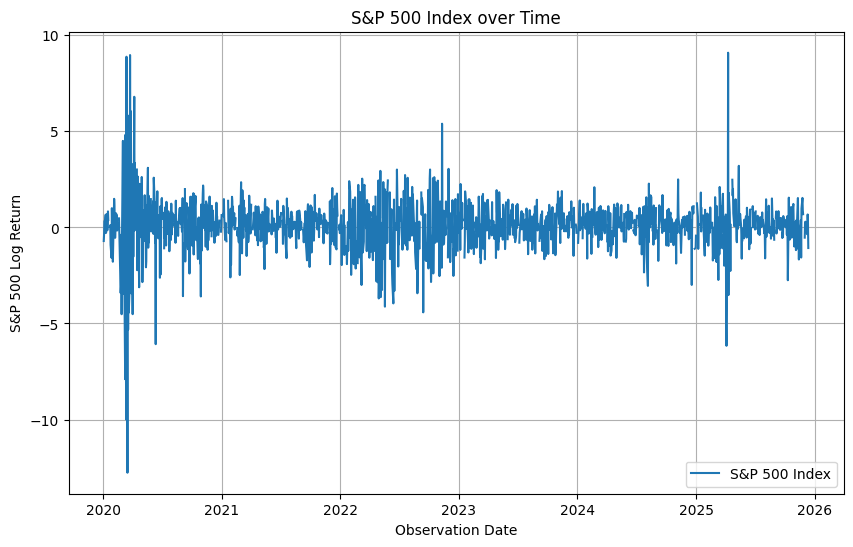

In [22]:
df_sp = pd.read_csv('data/task_4/sp500.csv')
df_sp.columns = df_sp.columns.str.lower()
df_sp["observation_date"] = pd.to_datetime(df_sp["observation_date"])
df_sp["sp500_log_return"] = np.log(df_sp["sp500"] / df_sp["sp500"].shift(1)) * 100
df_sp = df_sp.drop(['sp500'], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(df_sp["observation_date"], df_sp["sp500_log_return"], label="S&P 500 Index")
plt.title("S&P 500 Index over Time")
plt.xlabel("Observation Date")
plt.ylabel("S&P 500 Log Return")
plt.legend()
plt.grid()
plt.show()

In [23]:
returns = df_sp["sp500_log_return"].dropna()

In [24]:
garch = arch_model(returns, mean="Constant", vol="GARCH", p=1, o=0, q=1, dist="normal")
garch_res = garch.fit(disp="off")
print("Results for GARCH(1,1)")
print(garch_res.summary())

Results for GARCH(1,1)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       sp500_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2080.35
Distribution:                  Normal   AIC:                           4168.70
Method:            Maximum Likelihood   BIC:                           4189.79
                                        No. Observations:                 1439
Date:                Tue, Dec 16 2025   Df Residuals:                     1438
Time:                        15:51:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0951  2.309e-02      4.1

In [25]:
tgarch = arch_model(returns, mean="Constant", vol="GARCH", p=1, o=1, q=1, dist="normal")
tgarch_res = tgarch.fit(disp="off")
print("Results for TGARCCH(1,1)")
print(tgarch_res.summary())

Results for TGARCCH(1,1)
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:       sp500_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2064.84
Distribution:                  Normal   AIC:                           4139.69
Method:            Maximum Likelihood   BIC:                           4166.05
                                        No. Observations:                 1439
Date:                Tue, Dec 16 2025   Df Residuals:                     1438
Time:                        15:51:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0588  2.290e-02      2

In [26]:
print(f"AIC Garch (1,1): {garch_res.aic} vs AIC TGARCH: {tgarch_res.aic}")
print(f"BIC Garch (1,1): {garch_res.bic} vs BIC TGARCH: {tgarch_res.bic}")

AIC Garch (1,1): 4168.703634823847 vs AIC TGARCH: 4139.687352186806
BIC Garch (1,1): 4189.790449651397 vs BIC TGARCH: 4166.045870721243


Since the AIC is lower for the TGARCH over the GARCH(1,1), the TGARCH is the preferred model.

# Task 5

In [27]:
df_sp = pd.read_csv("data/task_4/sp500.csv")
df_sp.columns = df_sp.columns.str.lower()
df_sp["observation_date"] = pd.to_datetime(df_sp["observation_date"])
df_sp["log_sp500"] = np.log(df_sp["sp500"])
df_sp = df_sp[["observation_date", "log_sp500"]]

df_nasdaq = pd.read_csv("data/task_5/NASDAQCOM.csv")
df_nasdaq.columns = df_nasdaq.columns.str.lower()
df_nasdaq["observation_date"] = pd.to_datetime(df_nasdaq["observation_date"])
df_nasdaq["log_nasdaq"] = np.log(df_nasdaq["nasdaqcom"])
df_nasdaq = df_nasdaq[["observation_date", "log_nasdaq"]]

df = pd.merge(df_sp, df_nasdaq, on="observation_date", how="inner").dropna()

In [28]:
p_all = coint(df["log_sp500"], df["log_nasdaq"])[1]

end_date = df["observation_date"].max()
start_date = end_date - pd.DateOffset(years=1)
df_1y = df[df["observation_date"] >= start_date].copy()
p_red = coint(df_1y["log_sp500"], df_1y["log_nasdaq"])[1]

print("Full sample p-val:", p_all)
print("Last 1 year p-val:", p_red)

Full sample p-val: 0.5646482788047645
Last 1 year p-val: 0.017565644598149688


## 5 a
The EG Cointegration test yields a p-value > 0.05 for the full sample. Therefore there is no evidence for cointegration between the S&P 500 and NASDAQ. 

## 5b
When reducing the samples to last year though, the p-value is < 0.05 which allows us to reject the null hypothesis of no cointegration. The S&P500 and NASDAQ have therefore shown significant co-movement recently, but this does not generalize well over the entire time horizon of several years.